In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
df= pd.read_csv('../Dataset/GoodReadsShrink/goodreads_reviews_shrink.csv')
print(df.shape)
df.head()


(1000000, 5)


,user_id,book_id,review_id,review_text,rating
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,Mind blowingly cool. Best science fiction I've...,5
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,This is a special book. It started slow for ab...,5
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,I haven't read a fun mystery book in a while a...,3
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,"Fun, fast paced, and disturbing tale of murder...",4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,A fun book that gives you a sense of living in...,4


In [5]:
df.isnull().sum()

user_id          0
book_id          0
review_id        0
review_text    465
rating           0
dtype: int64

In [6]:
df = df.dropna(subset=['review_text'])
df.isnull().sum()


user_id        0
book_id        0
review_id      0
review_text    0
rating         0
dtype: int64

In [7]:
df.shape

(999535, 5)

In [8]:
print("number of unique books: ", len(df['book_id'].unique()))
print("number of unique reviews: ", len(df['review_id'].unique()))

number of unique books:  395468
number of unique reviews:  999535


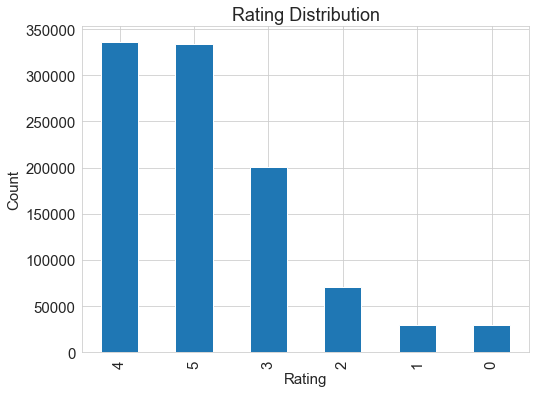

In [9]:
def plotHIST(df, col, xlab, ylab, title):
    sns.set_style("whitegrid")
    %matplotlib inline
    plt.figure(figsize=(8,6))
    plt.rc("font", size=15)
    df[col].value_counts(sort=True).plot(kind="bar")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

plotHIST(df, "rating","Rating", "Count", "Rating Distribution")

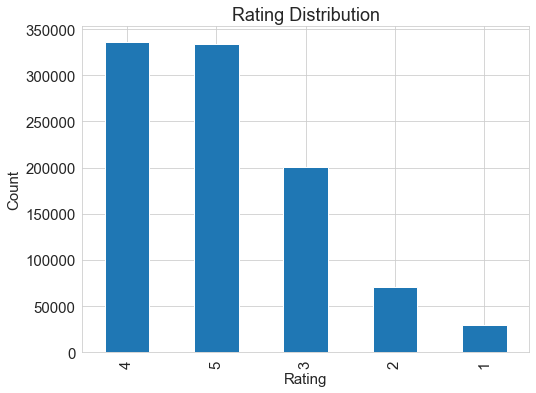

4    336260
5    334041
3    200271
2     70641
1     29166
Name: rating, dtype: int64

In [10]:
# remove rows with rating 0 (not rated)
df = df[df['rating'] != 0]
df.shape

plotHIST(df, "rating","Rating", "Count", "Rating Distribution")
df['rating'].value_counts()

In [11]:
# showing books
df['book_id'].value_counts()

11870085    1293
2767052      948
8442457      725
7260188      721
22557272     720
            ... 
16193865       1
18901793       1
18927423       1
24967821       1
15843480       1
Name: book_id, Length: 386266, dtype: int64

In [12]:
#there are books that have been rated only once
# SHRINKING THE DATASET BY REMOVING BOOKS THAT HAVE BEEN RATED LESS THAN 100 TIMES
counts = df['book_id'].value_counts()
df = df[df['book_id'].isin(counts[counts >= 100].index)]
print(df.shape)
df['book_id'].value_counts()

(95258, 5)


11870085    1293
2767052      948
8442457      725
7260188      721
22557272     720
            ... 
13623150     100
127455       100
18705209     100
26025580     100
27071490     100
Name: book_id, Length: 493, dtype: int64

In [13]:
df['user_id'].value_counts()

c4f655f2ed79599a9259d7762313f3f3    155
b9c0d56438ee6342288737820c9cdcbf    142
8e7e5b546a63cb9add8431ee6914cf59    127
004d5e96c8a318aeb006af50f8cc949c    125
763855e459b729245cde092c2798f3bc    124
                                   ... 
d65ba901c0672ca63c3420b572b9a150      1
0bbe18e8628359cf37c37669f08dff16      1
cb3237fafb03f5647a5cf7a49ac14b0e      1
8c2ed8c7a5779a8294f91185c3830960      1
bff0a68c5de2e613618392223eed8cb0      1
Name: user_id, Length: 13184, dtype: int64

In [14]:
# there are users that have rated only once
# SHRINKING THE DATASET BY REMOVING USERS THAT HAVE RATED LESS THAN 10 TIMES
counts = df["user_id"].value_counts()
df = df[df["user_id"].isin(counts[counts >= 20].index)]
print(df.shape)
df["user_id"].value_counts()

(41432, 5)


c4f655f2ed79599a9259d7762313f3f3    155
b9c0d56438ee6342288737820c9cdcbf    142
8e7e5b546a63cb9add8431ee6914cf59    127
004d5e96c8a318aeb006af50f8cc949c    125
763855e459b729245cde092c2798f3bc    124
                                   ... 
a71473fe97fa16106545b53ba66bac0c     20
92e254c37668adc94ef3a2df2162635b     20
0600fbc008943e9eba278d4fd1d15ce6     20
8495c4332e4df6496002107707f960d1     20
753513e91870af26bb1f726643c22c23     20
Name: user_id, Length: 1162, dtype: int64

In [15]:
print(df.shape)
df.head()


(41432, 5)


,user_id,book_id,review_id,review_text,rating
501,01ec1a320ffded6b2dd47833f2c8e4fb,18812405,5a81d68f7eaa7aaad499dfd0a6c97824,Well. I was prepared to love this book. Even t...,4
517,01ec1a320ffded6b2dd47833f2c8e4fb,7937843,cf94492e1449528b471fb6b5a9f82d74,Absolute unforgettable story of the power of a...,5
767,01ec1a320ffded6b2dd47833f2c8e4fb,24920901,b0a118c65aa9d97a62c2c02157bf5af3,"4.5 - 5 Sexy - Sweet Stars!! \n Hello, Elle Ke...",5
785,01ec1a320ffded6b2dd47833f2c8e4fb,27362503,849d3df919cf08a01c3d24ed9732ca63,"""Someone once told me that there is no such th...",5
843,01ec1a320ffded6b2dd47833f2c8e4fb,24378015,847c8dc0abbd022367b83953af51ad43,What do you get when you mix Colleen Hoover an...,5


In [16]:
#number of unique users and books
print("Number of unique users: ", df["user_id"].nunique())
print("Number of unique books: ", df["book_id"].nunique())

Number of unique users:  1162
Number of unique books:  493


In [17]:
df.to_csv("data_top.csv", index=False)

In [19]:
# CREATING USER-ITEM MATRIX
userBookRating = df.pivot_table(index=["user_id"], columns=["book_id"], values="rating")
print(userBookRating.shape)
userBookRating.head()

(1162, 493)


book_id,1,2,3,5,6,11,320,865,890,930,...,27883214,28187230,28260587,28587957,28763485,29056083,29069989,29780253,30555488,32075671
user_id,,,,,,,,,,,,,,,,,,,,,
004d5e96c8a318aeb006af50f8cc949c,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,3.0,2.0,5.0,5.0,NaN,5.0,NaN,NaN,2.0,5.0
00660d8ef237d83e8b412c3d6d85b860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0076463c51f453d754cdd95dfb579dc5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009ed6643b45c30f1c759284a72a9365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
00ce07379fb4a962964dcfde4e146a84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
import numpy as np
import pandas as pd
import scipy as sp
# import AgglomerativeClustering from sklearn
from sklearn.cluster import AgglomerativeClustering
from math import sqrt


In [21]:
# Creating MxN matrix where M is the number of users and N is the number of books
# an Example of the representation of the matrix is shown below
#       Items  I1        I2        I3      I4      I5
# Users
# U1           1.0       4.0       5.0     3.0     2.0
# U2           2.0       3.0       4.0     5.0     1.0
# U3           0.0       4.0       3.0     0.0     1.0
# U4           1.0       2.0       3.0     4.0     5.0
# U5           5.0       4.0       3.0     2.0     1.0


user_ID_test = "004d5e96c8a318aeb006af50f8cc949c"
book_ID_test = "1"
rating_matrix = df.pivot_table(index=["user_id"], columns=["book_id"], values="rating")
print(rating_matrix.shape)
rating_matrix.head()






(1162, 493)


book_id,1,2,3,5,6,11,320,865,890,930,...,27883214,28187230,28260587,28587957,28763485,29056083,29069989,29780253,30555488,32075671
user_id,,,,,,,,,,,,,,,,,,,,,
004d5e96c8a318aeb006af50f8cc949c,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,3.0,2.0,5.0,5.0,NaN,5.0,NaN,NaN,2.0,5.0
00660d8ef237d83e8b412c3d6d85b860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0076463c51f453d754cdd95dfb579dc5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009ed6643b45c30f1c759284a72a9365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
00ce07379fb4a962964dcfde4e146a84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
mean_centered_matrix = rating_matrix.sub(rating_matrix.mean(axis=1), axis=0)
print(mean_centered_matrix.shape)
mean_centered_matrix.head()


(1162, 493)


book_id,1,2,3,5,6,11,320,865,890,930,...,27883214,28187230,28260587,28587957,28763485,29056083,29069989,29780253,30555488,32075671
user_id,,,,,,,,,,,,,,,,,,,,,
004d5e96c8a318aeb006af50f8cc949c,NaN,NaN,NaN,NaN,NaN,NaN,-1.576,NaN,NaN,NaN,...,-0.576,-1.576,1.424,1.424,NaN,1.424000,NaN,NaN,-1.576,1.424
00660d8ef237d83e8b412c3d6d85b860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0076463c51f453d754cdd95dfb579dc5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009ed6643b45c30f1c759284a72a9365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.136364,NaN,NaN,NaN,NaN
00ce07379fb4a962964dcfde4e146a84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User-based collaborative filtering

In [23]:
user_pearson_similarity_matrix = rating_matrix.copy()

# use corr function to calculate pearson correlation between users (columns)
user_pearson_similarity_matrix = user_pearson_similarity_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_pearson_similarity_matrix = user_pearson_similarity_matrix.T.corr(method="pearson")





In [24]:

def similar_users(userID: str, top_percent: int, threshold: float = 0.2):
    index = rating_matrix.index.get_loc(userID)
    row_rating = user_pearson_similarity_matrix.iloc[index]
    row_rating.sort_values(ascending=False, inplace=True)
    top_users = round(len(user_pearson_similarity_matrix) * top_percent)
    user_list = list(row_rating.index[1:top_users+1])
    # remove users with similarity less than threshold
    user_list = [user for user in user_list if row_rating[user] > threshold]
    return user_list

def find_not_rated_books(userID: str):
    not_rated_books = rating_matrix.loc[userID][rating_matrix.loc[userID].isnull()].index
    return list(not_rated_books)


# this function predicts the rating of the missing values in the rating matrix for a given user given a list of similar users
def predict_rating_user(userID: str , userIDs: list):
    # get the not rated books by the user
    not_rated_books = find_not_rated_books(userID)
    # dictionary to store the predicted rating for each book
    prediction_dict = {}
    for book in not_rated_books:
        numerator = 0
        denominator = 0
        for user in userIDs:
            if not np.isnan(rating_matrix.loc[user][book]):
                numerator += user_pearson_similarity_matrix.loc[userID][user] * mean_centered_matrix.loc[user][book]
                denominator += user_pearson_similarity_matrix.loc[userID][user]
        if denominator != 0:
            prediction_dict[book] = numerator / denominator + rating_matrix.loc[userID].mean()
    
    # sort the dictionary by the predicted rating in descending order
    prediction_dict = {i: v for i, v in sorted(prediction_dict.items(), key=lambda item: item[1], reverse=True)}
    return prediction_dict



In [25]:
top_users_percent = 0.3
mylist = similar_users("004d5e96c8a318aeb006af50f8cc949c", top_users_percent)
user_based_prediction = predict_rating_user("004d5e96c8a318aeb006af50f8cc949c", mylist)
print("recommended books for user are: (Item: Rating Prediction)")
print(user_based_prediction)



recommended books for user are: (Item: Rating Prediction)
{127455: 5.0574814814814815, 1215032: 5.0574814814814815, 6690798: 4.0574814814814815, 15729539: 4.0574814814814815, 18302455: 4.0574814814814815, 11735983: 3.8335816274910766, 2657: 3.6176666666666666, 14050: 3.6176666666666666, 14891: 3.6176666666666666, 2118745: 3.6176666666666666, 2767052: 3.6176666666666666, 4667024: 3.6176666666666666, 6148028: 3.6176666666666666, 6218281: 3.6176666666666666, 7331435: 3.6176666666666666, 8306857: 3.6176666666666666, 8490112: 3.6176666666666666, 9118135: 3.6176666666666666, 9418327: 3.6176666666666666, 9673436: 3.6176666666666666, 9736930: 3.6176666666666666, 10335308: 3.6176666666666666, 28763485: 3.6176666666666666, 6288: 3.3426591902482072, 3636: 3.0574814814814815, 13335037: 3.0574814814814815, 16278318: 3.0574814814814815, 18710190: 3.0574814814814815, 21535271: 2.0574814814814815, 5107: 1.0574814814814815}


## Item-based collaborative filtering

In [26]:
item_pearson_similarity_matrix = rating_matrix.copy()
# use corr function to calculate pearson correlation between users (columns)
item_pearson_similarity_matrix = item_pearson_similarity_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
item_pearson_similarity_matrix = item_pearson_similarity_matrix.corr(method="pearson")

In [27]:
def similar_items(itemID: str, top_items_number: int = len(rating_matrix.columns), threshold: float = 0.2):
    index = rating_matrix.columns.get_loc(itemID)
    coloumn_rating = item_pearson_similarity_matrix.iloc[index]
    coloumn_rating.sort_values(ascending=False, inplace=True)
    top_items = min(len(item_pearson_similarity_matrix), top_items_number)
    item_list = list(coloumn_rating.index[1:top_items+1])
    # remove items with similarity less than threshold
    item_list = [item for item in item_list if coloumn_rating[item] > threshold]
    return item_list



def predict_rating_item(userID: str):
    not_rated_books = find_not_rated_books(userID)
    # dictionary to store the predicted rating for each book
    prediction_dict = {}
    top_items_number = round(sqrt(len(rating_matrix.columns)))

    for book in not_rated_books:
        similar_books = similar_items(book, top_items_number)
        # print("similar books for book {} are:".format(book))
        # print(similar_books)
        numerator = 0
        denominator = 0
        for item in similar_books:
            if not np.isnan(rating_matrix.loc[userID][item]):
                numerator += item_pearson_similarity_matrix.loc[book][item] * rating_matrix.loc[userID][item]
                denominator += item_pearson_similarity_matrix.loc[book][item]
                # print("denominator: {}".format(denominator))
        if denominator != 0:
            prediction_dict[book] = numerator / denominator
        # print("----------------------------------------")
    # sort the dictionary by the predicted rating in descending order
    prediction_dict = {i: v for i, v in sorted(prediction_dict.items(), key=lambda item: item[1], reverse=True)}
    return prediction_dict

#### Item-based collaborative filtering test

In [28]:
# case item searched, with no clue who the user is
# item_prediction = similar_items(968)
# print(item_prediction)

# case user logged in
item_based_prediction = predict_rating_item(user_ID_test)
print(item_based_prediction)



{41865: 4.002808133903028, 13335037: 3.9930838480655346, 960: 3.6744365270772508, 6334: 3.3414063083595504, 17788401: 3.3342010288491077, 10917: 3.253121806994873, 5470: 3.2488116844811734, 15839984: 3.2487635303058515, 28187: 3.245752412876166, 186074: 3.200419752127759, 6131164: 3.1994802276688943, 237209: 3.0093508940631257, 6068551: 3.0059784896407993, 23437156: 3.004971578012083, 18405: 3.0043063907535297, 10441: 3.0042661432300015, 375802: 3.003779351558466, 22628: 3.0030264226246652, 6931356: 3.003010056930576, 10025305: 3.0026001900503307, 6892870: 3.001514559761431, 12881778: 3.0000000000000004, 3: 3.0, 2914097: 3.0, 6339664: 3.0, 10818853: 3.0, 13414446: 3.0, 13644052: 3.0, 17333880: 3.0, 18143950: 3.0, 20639274: 3.0, 22489107: 3.0, 25111004: 3.0, 5: 2.9999999999999996, 301082: 2.9999999999999996, 9593913: 2.9999999999999996, 18593175: 2.9999999999999996, 2728527: 2.999810074777555, 10626594: 2.999735149476958, 7735333: 2.9993791527863083, 4374400: 2.9993207652588634, 1734738

## Final predictions & statistics

In [29]:
user_mean = rating_matrix.loc[user_ID_test].mean()
print("user mean: {}".format(user_mean))

## calculating average prediction from item and user CF
average_prediction = {}
common_items = set(item_based_prediction.keys()).intersection(set(user_based_prediction.keys()))
for item in common_items:
    average_prediction[item] = (item_based_prediction[item] + user_based_prediction[item]) / 2

print(average_prediction)

# calculating the RMSE
def rmse(prediction_dict: dict, user_mean: float):
    rmse = 0
    for item in prediction_dict:
        rmse += (prediction_dict[item] - user_mean) ** 2
    rmse = sqrt(rmse / len(prediction_dict))
    return rmse


print("RMSE for user based CF: {}".format(rmse(user_based_prediction, user_mean)))
print("RMSE for item based CF: {}".format(rmse(item_based_prediction, user_mean)))
print("RMSE for average prediction: {}".format(rmse(average_prediction, user_mean)))




user mean: 3.576
{8490112: 2.3088333333333333, 15729539: 3.1954683916310658, 6288: 2.6717437961900847, 4667024: 3.0573934176012987, 21535271: 2.030507087321427, 6218281: 2.8110749592686037, 8306857: 2.80897755963307, 14891: 3.1416921043138606, 16278318: 2.529838315610551, 11735983: 3.1713054725607477, 18710190: 2.0287407407407407, 3636: 2.5315028576996492, 9118135: 2.808789028154163, 1215032: 3.528153158375642, 6148028: 2.8112243825265035, 2767052: 3.1419832734953044, 10335308: 2.8107201823188848, 9418327: 2.8087838046054787, 2118745: 3.141065061127996, 9673436: 2.806711176445153, 28763485: 2.808204861006646, 127455: 3.5297072028700835, 2657: 2.8113332027997, 14050: 2.975845389478243, 9736930: 3.183486557008852, 7331435: 2.8092073943770757, 6690798: 3.1956829901555492, 5107: 1.863757679044312, 18302455: 3.361834734340806, 13335037: 3.525282664773508}
RMSE for user based CF: 0.706154798033461
RMSE for item based CF: 1.4409562317898674
RMSE for average prediction: 0.8175943821342123
